In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

In [41]:
# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Read in the data
df = pd.read_excel('../data/Maersk_Supply_Combined.xlsx')
df = df[(df['EBS1'].notna()) & (df['EBS1'] != ' ')]
df['EBS1'] = df['EBS1'].apply(lambda x: x.strip())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
# Handling rare classes before encoding
class_counts = df['EBS1'].value_counts()
threshold = 2  # Minimum number of instances required
rare_classes = class_counts[class_counts < threshold].index.tolist()
df_filtered = df[~df['EBS1'].isin(rare_classes)]

# Create a separate status list which we will use as labels 
status = list(df_filtered['EBS1'])

# Create a df which contains the columns we will use for prediction
df_filtered = df_filtered[['Object', 'Group', 'Object_Type', 'Directive', 'Work_Description', 'Completion_Note', 'EBS1']]

# Fill the N/A cells, lowercase the dataframe, and combine columns and create a combined column
df_filtered = df_filtered.fillna('')
for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].str.lower()
df_filtered['combined'] = df_filtered.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Replace the carriage return characters with a space
for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].str.replace('_x000d_\n', ' ', regex=False)

# Lemmatization and stopword removal
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def nltk_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def preproces_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, nltk_pos(tag)) if nltk_pos(tag) else token for token, tag in tagged_tokens]
    cleaned_token = [token for token in lemmatized_tokens if token not in stop_words and token.isalpha()]
    return ' '.join(cleaned_token)

# Apply our lemmatization code and lower case our combined column
df_filtered['combined'] = df_filtered['combined'].apply(preproces_text)

In [43]:
# Create our vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=20000, stop_words='english')

# Encode the target column after filtering rare classes
encoder = LabelEncoder()
df_filtered['EBS1'] = encoder.fit_transform(df_filtered['EBS1'].astype(str))

# Split the data into its constituent parts (description and status) and then create a prediction
X = df_filtered['combined']
y = df_filtered['EBS1']
X_vec = vectorizer.fit_transform(X)

# Check if the length of X and y are consistent
assert len(X) == len(y), "Mismatch in the number of samples between X and y"

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 1200, 'solver': 'sgd', 'verbose': True}

# Create a pipeline with scaler, PCA, and MLPClassifier
pipeline = ImbPipeline([
    ('scaler', MaxAbsScaler()),  # Apply scaler after TF-IDF transformation
    ('pca', PCA(n_components=100)),  # Reduce to 100 principal components
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', MLPClassifier(**params))
])

# Fit the full pipeline
pipeline.fit(X_train, y_train)

Iteration 1, loss = 3.28859328
Iteration 2, loss = 3.02803624
Iteration 3, loss = 2.80395282
Iteration 4, loss = 2.61430628
Iteration 5, loss = 2.44703563
Iteration 6, loss = 2.29393036
Iteration 7, loss = 2.15074294
Iteration 8, loss = 2.01583249
Iteration 9, loss = 1.88839291
Iteration 10, loss = 1.76876643
Iteration 11, loss = 1.65669869
Iteration 12, loss = 1.55276286
Iteration 13, loss = 1.45679297
Iteration 14, loss = 1.36857895
Iteration 15, loss = 1.28776361
Iteration 16, loss = 1.21389828
Iteration 17, loss = 1.14683683
Iteration 18, loss = 1.08560246
Iteration 19, loss = 1.02987897
Iteration 20, loss = 0.97889544
Iteration 21, loss = 0.93244521
Iteration 22, loss = 0.88991280
Iteration 23, loss = 0.85088142
Iteration 24, loss = 0.81497941
Iteration 25, loss = 0.78194949
Iteration 26, loss = 0.75137870
Iteration 27, loss = 0.72303204
Iteration 28, loss = 0.69660922
Iteration 29, loss = 0.67192169
Iteration 30, loss = 0.64891270
Iteration 31, loss = 0.62733619
Iteration 32, los

Pipeline(steps=[('scaler', MaxAbsScaler()), ('pca', PCA(n_components=100)),
                ('sampler', RandomOverSampler(random_state=42)),
                ('classifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100),
                               learning_rate='adaptive', max_iter=1200,
                               solver='sgd', verbose=True))])

In [44]:
# Evaluate on the test set
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test accuracy:  0.972972972972973
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           4       0.99      1.00      1.00       120
           6       0.81      1.00      0.89        25
           7       1.00      0.99      0.99        78
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       0.94      1.00      0.97        16
          12       1.00      1.00      1.00         9
          13       1.00      0.93      0.97        92
          14       1.00      0.50      0.67         2
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         6
          18       0.00 

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and b

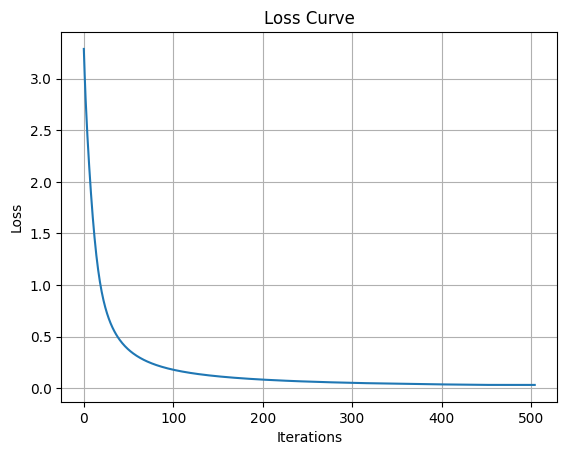

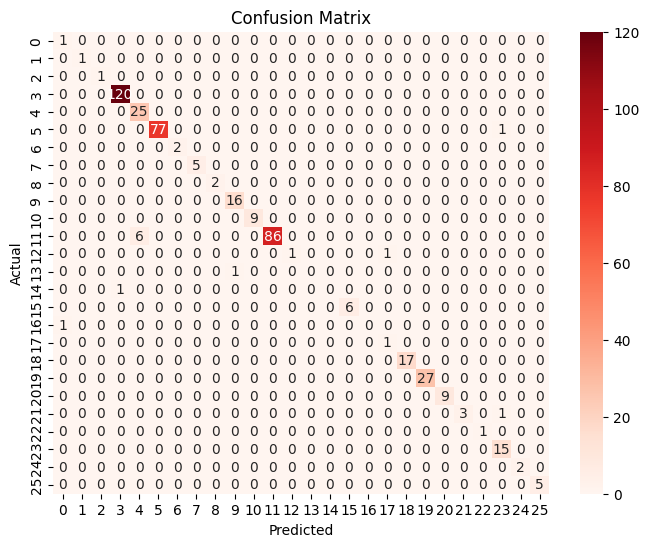

In [45]:
# Plot the loss curve
classifier = pipeline.named_steps['classifier']
plt.plot(classifier.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()